In [1]:
import os

os.chdir("../..")

In [2]:
from datetime import datetime, timezone
from typing import Dict, List, Literal, cast
import os 
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_openai import ChatOpenAI as LangchainChatOpenAI
# from langchain_core.messages import HumanMessage, SystemMessage, MessagesPlaceholder
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from src.react_agent.configuration import Configuration
from src.react_agent.state import InputState, OverallState, OutputState
from src.react_agent.tools import TOOLS
from src.react_agent.utils import load_chat_model
from typing import Any, List, Optional, Union
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from dataclasses import dataclass, field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI as LangchainChatDeepSeek
from langchain_core.prompts import MessagesPlaceholder
from langchain.schema import HumanMessage, SystemMessage, AIMessage  # Import AIMessage for assistant responses
from langgraph.checkpoint.memory import MemorySaver

import logging

# Suppress debug messages from ipywidgets
logging.getLogger('ipywidgets').setLevel(logging.WARNING)
# Suppress debug messages from the comm module
logging.getLogger('comm').setLevel(logging.WARNING)
# Define the state object
# state = OverallState()

from src.react_agent.agent import ( travel_itinerary_planner, flight_finder_tool_node,
                                accommodation_finder_node, activities_node, ticketmaster_node, recommendations_node)

from src.react_agent.tools import (TOOLS, amadeus_tool, amadeus_hotel_tool, geoapify_tool, weather_tool,  AmadeusFlightSearchInput,
                                   FlightSearchInput,
                                   googlemaps_tool, flight_tool, google_scholar_tool, booking_tool, tavily_search_tool,
                                   flight_tools_condition, accomodation_tools_condition, activity_planner_tools_condition,
                                   multiply_tool, GoogleMapsPlacesInput, google_places_tool, google_find_place_tool, google_place_details_tool,
                                   google_events_tool, GoogleEventsSearchInput, TicketmasterEventSearchInput, ticketmaster_tool,)


from langchain.agents import create_react_agent, AgentExecutor
from src.react_agent.prompts import SYSTEM_PROMPT, FLIGHT_FINDER_PROMPT, ACTIVITY_PLANNER_PROMPT, RECOMMENDATION_PROMPT
from langchain.tools import BaseTool, Tool
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langgraph.prebuilt import tools_condition

from datetime import date
import logging

# Suppress debug messages from ipywidgets
logging.getLogger('ipywidgets').setLevel(logging.WARNING)
logging.getLogger('comm').setLevel(logging.WARNING)
logging.getLogger('tornado').setLevel(logging.WARNING)
logging.getLogger('traitlets').setLevel(logging.WARNING)

# Disable all logging globally
logging.disable(logging.CRITICAL)  # Disable all logging below CRITICAL level

# Redirect all logging output to os.devnull
logging.basicConfig(level=logging.CRITICAL, handlers=[logging.NullHandler()])

# Suppress warnings as well (optional)
import warnings
warnings.filterwarnings("ignore")

INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60


✅ API keys validated.


DEBUG:pydot:pydot initializing
DEBUG:pydot:pydot 3.0.4
DEBUG:pydot.dot_parser:pydot dot_parser module initializing
DEBUG:pydot.core:pydot core module initializing
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\pault\\anaconda3\\envs\\app_project\\Library\\ssl\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\pault\\anaconda3\\envs\\app_project\\Library\\ssl\\cacert.pem'


In [3]:
llm = LangchainChatDeepSeek(
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    model= "deepseek-chat",
    base_url="https://api.deepseek.com",
)

user_input = """
so I wanna go to New York City from Oklahoma and I'm pretty much looking for the best flights the most affordable flights that you c
an get for me I want to go so today is 30th of January which means I would like to go in let's say in five days and I would like to 
come back five days later, keep in mind the year is 2025, right and I would be probably lodging in New Jersey even though I'm going to 
New York City I would lodge in New Jersey because it's affordable I would like to lodge in an Airbnb preferably and some of the things 
I would like to see you know I like the nightlife so I would prefer to go to nightclubs and dance and party and you know that's what 
I would like to do lots of nightlife lots of food I also would like to try in Nigerian restaurants in New York City so any way I can get 
Nigerian food that would be really really appreciated you know I would also like to relax go to the park and chill

"""    


> Test

In [4]:
def flight_tools_condition(
    state: Union[list[AnyMessage], dict[str, Any], BaseModel],
    messages_key: str = "messages",
) -> Literal["flight_tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end.

    Args:
        state (Union[list[AnyMessage], dict[str, Any], BaseModel]): The state to check for
            tool calls. Must have a list of messages (MessageGraph) or have the
            "messages" key (StateGraph).

    Returns:
        The next node to route to.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "flight_tools"
    return "__end__"    # you can change this to any other node name instead of "__end__"


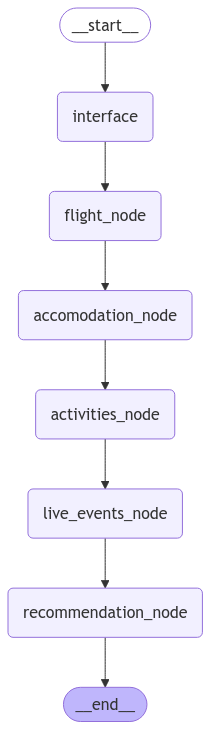

In [5]:
# Define a new graph
builder = StateGraph(OverallState, config_schema=Configuration)
builder.add_node("interface", travel_itinerary_planner)
builder.add_node("flight_node", flight_finder_tool_node)
builder.add_node("accomodation_node", accommodation_finder_node)
builder.add_node("activities_node", activities_node)
builder.add_node("live_events_node", ticketmaster_node)
builder.add_node("recommendation_node", recommendations_node)

builder.add_edge(START, "interface")
builder.add_edge("interface", "flight_node")
builder.add_edge("flight_node", "accomodation_node")
builder.add_edge("accomodation_node", "activities_node")
builder.add_edge("activities_node", "live_events_node")
builder.add_edge("live_events_node", "recommendation_node")
builder.add_edge("recommendation_node", END)

graph = builder.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [7]:
# **Input Collection**
# user_input = "I want to travel from Los Angeles to New York on 2025-2-15 and return on 2025-2-22 via La Guardia Airport. There is 1 adult. My budget is $5000. I need 1 room in The Bronx for 5 days. I prefer an AirBnB with free breakfast and a swimming pool. I also want to visit the museums and enjoy local cuisine, and go to the club at night. I might also want a massage."    


# **Input State**
input_state = {"messages": [HumanMessage(content=user_input)]}

# **Graph Invocation**
output = graph.invoke(input_state, {"recursion_limit": 3000})
# output.get("messages")[-1].content



In [21]:
output['messages'][0].content

"\nso I wanna go to New York City from Oklahoma and I'm pretty much looking for the best flights the most affordable flights that you c\nan get for me I want to go so today is 30th of January which means I would like to go in let's say in five days and I would like to \ncome back five days later, keep in mind the year is 2025, right and I would be probably lodging in New Jersey even though I'm going to \nNew York City I would lodge in New Jersey because it's affordable I would like to lodge in an Airbnb preferably and some of the things \nI would like to see you know I like the nightlife so I would prefer to go to nightclubs and dance and party and you know that's what \nI would like to do lots of nightlife lots of food I also would like to try in Nigerian restaurants in New York City so any way I can get \nNigerian food that would be really really appreciated you know I would also like to relax go to the park and chill\n\n"

In [8]:
output['recommendations']

[{'Weather Forecast': '"Expect cold temperatures (25°F to 40°F) with possible snow or rain. Pack warm, waterproof clothing and layers."'},
 {'Crime Rate': '"New York City is generally safe, but be cautious of pickpocketing in crowded areas. Avoid poorly lit streets at night."'},
 {'Emergency Services': '"Dial 911 for emergencies and 311 for non-emergency police assistance."'},
 {'Local Customs': '"Tipping is customary (15-20% in restaurants, $1-2 per drink in bars). Dress codes in nightclubs can be strict."'},
 {'Local Laws': '"Smoking is banned indoors, and public drinking is illegal. Be mindful of noise ordinances in residential areas."'},
 {'Currency & Exchange': '"U.S. dollars are used. Credit cards are widely accepted, but carry some cash for smaller establishments."'},
 {'Health Requirements': '"No special vaccinations are needed. Tap water is safe to drink. Pharmacies like CVS are widespread."'},
 {'Connectivity': '"Purchase a SIM card at the airport or major stores. Free Wi-Fi 